# CartPole-v0 - REINFORCE

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Categorical

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
env = gym.make('CartPole-v0')
env.seed(0)

print('Observation Space: ', env.observation_space)
print('Action Space: ', env.action_space)

Observation Space:  Box(4,)
Action Space:  Discrete(2)


In [4]:
s_size = 4
a_size = 2

print(s_size, a_size)

4 2


## Policy

In [5]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16 ,a_size=2):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        
        m = Categorical(probs)
        action = m.sample()
        
        return action.item(), m.log_prob(action)
        

## Training Agent

In [6]:
policy = Policy().to(device)

optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [7]:
def reinforce(eps=1000, max_t=1000, gamma=1.0, pe=100):
    
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i in range(1, eps+1):
        
        saved_log_probs = []
        rewards = []
        
        state = env.reset()
        
        for t in range(max_t):
            
            action, log_prob = policy.act(state)
            state, reward, done, _ = env.step(action)
            
            saved_log_probs.append(log_prob)
            rewards.append(reward)
            
            if done:
                break

        r = sum(rewards)
        scores_deque.append(r)
        scores.append(r)
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = [a*b for a,b in zip(discounts, rewards)]
        R = sum(R)
        
        policy_loss = []
        for log_prob in saved_log_probs:
            pl = -log_prob * R
            policy_loss.append(pl)
            
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i % pe == 0:
            print('Episode {}\tAvg Score {:.2f}'.format(i, np.mean(scores_deque)))
        
        if np.mean(scores_deque) >=195.0:
            print('[Solved] Episodes {:d}\t Avg Score {:.2f}'.format(i-100, np.mean(scores_deque)))
            break
            
    return scores

scores = reinforce()

Episode 100	Avg Score 34.47
Episode 200	Avg Score 66.26
Episode 300	Avg Score 87.82
Episode 400	Avg Score 72.84
Episode 500	Avg Score 161.75
Episode 600	Avg Score 176.04
Episode 700	Avg Score 143.40
Episode 800	Avg Score 166.39
Episode 900	Avg Score 139.92
Episode 1000	Avg Score 156.56


## Scores

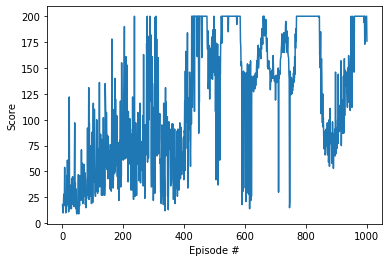

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores)+1)
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Watch the trained Agent

In [9]:
from gym import wrappers

env_to_wrap = gym.make('CartPole-v0')
env = wrappers.Monitor(env_to_wrap, 'vid', force=True)

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break

In [10]:
env.close()